In [1]:
#coding: utf-8

import warnings
warnings.simplefilter("ignore")

import os
import sys 
import wave
import time
import librosa
import numpy as np
import seaborn as sns
from utils import *
import matplotlib.pyplot as plt
from StringIO import StringIO

%pylab inline

# sudo pip install librosa
# ubuntu: sudo apt-get install libav-tools
# OSX   : brew install libav OMP_NUM_THREADS=2

Populating the interactive namespace from numpy and matplotlib


# Get the Data

Датасет для контеста помещен вот здесь: https://yadi.sk/d/3jmeVCfSwTKgm (внимание! файл весит 3,5 Гб)


Он распаковывается в папку "musicdata". Все пути в этом ноутбуке будут относительно этой папки: "./musicdata/\*". 

Вы можете изменить базовый путь, как вам удобно.

In [2]:
BP = "./musicdata/"

# Just a Sound

Для начала попробуем поработать со звуком - послушайте любой трек, постройте график сырых данных и спектрограмму.

In [3]:
import IPython
from IPython.display import HTML

def Audio(url):
    return HTML("<center><audio controls><source src='{}' type=\"audio/wav\"></audio>".format(url))

In [4]:
sound_file = os.path.join(BP, "audiosamples", "short_206377.wav")
# sound_file = BP + "/audiosamples/short_206377.wav"
y, sr = librosa.load(sound_file)

Audio(url=sound_file)

# Sound as 1D-Signal

In [5]:
len(y) / sr

10

In [6]:
from scipy.io import wavfile as wav
rate, data = wav.read(sound_file)

In [7]:
len(data)/rate

10

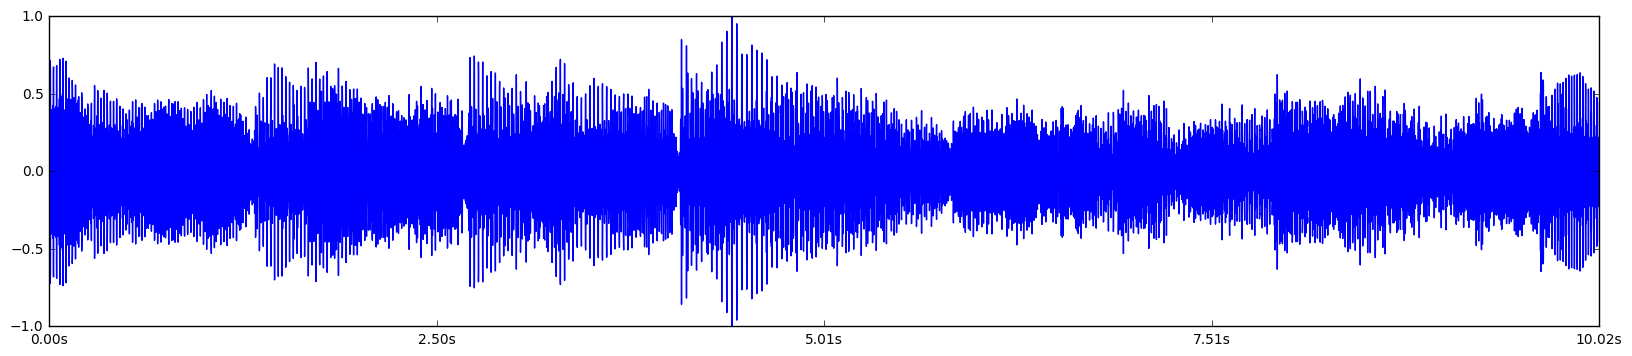

In [8]:
plt.figure(figsize=(20,4))
librosa.display.waveplot(y, sr=sr)

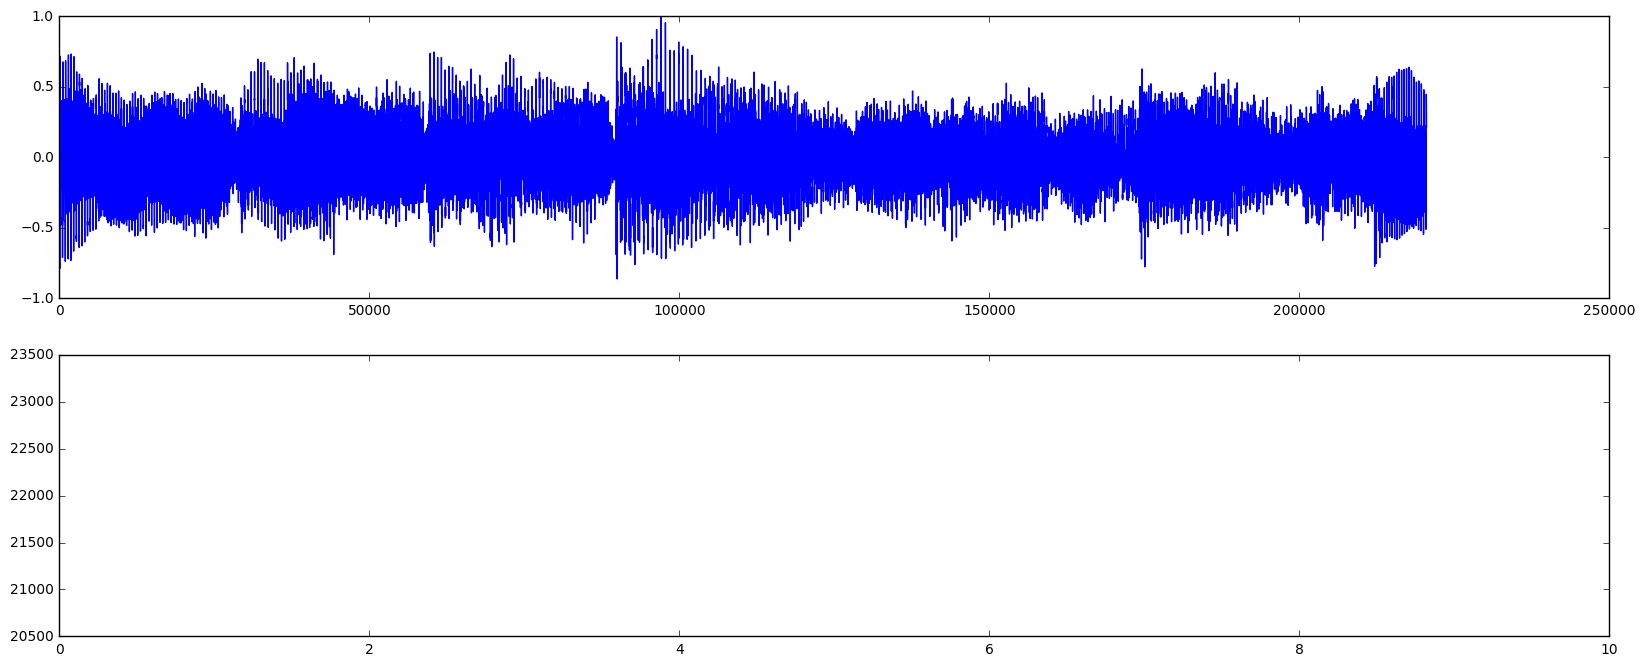

In [9]:
plt.figure(figsize=(20,8))
# 
# Используйте pylab.plot для построения графика, нарисуйте y, sr
#
plt.subplot(2, 1, 1)
pylab.plot(y)
plt.subplot(2, 1, 2)
pylab.plot(sr)
pylab.xlim([0, 10])
pylab.show()

# Sound as 2D-Signal

Нашу цель слелать из предыдущего графика картинку - для этого нам нужно оценить частоты в каждый момент времени. Благо за нас это умеет делать librosa, у которой внутри STFFT. Используйте librosa.feature.melspectrogram -- для получения спектрограммы, и librosa.logamplitude для выравнивания диапазонов частот. 

help: https://gist.github.com/mailletf/3484932dd29d62b36092

In [10]:
S = librosa.feature.melspectrogram(y, sr=sr, n_mels=128)
log_S = librosa.logamplitude(S, ref_power=np.max)

In [11]:
y.shape

(220500,)

Нарисуйте спектрограмму, получилась красивая картинка?

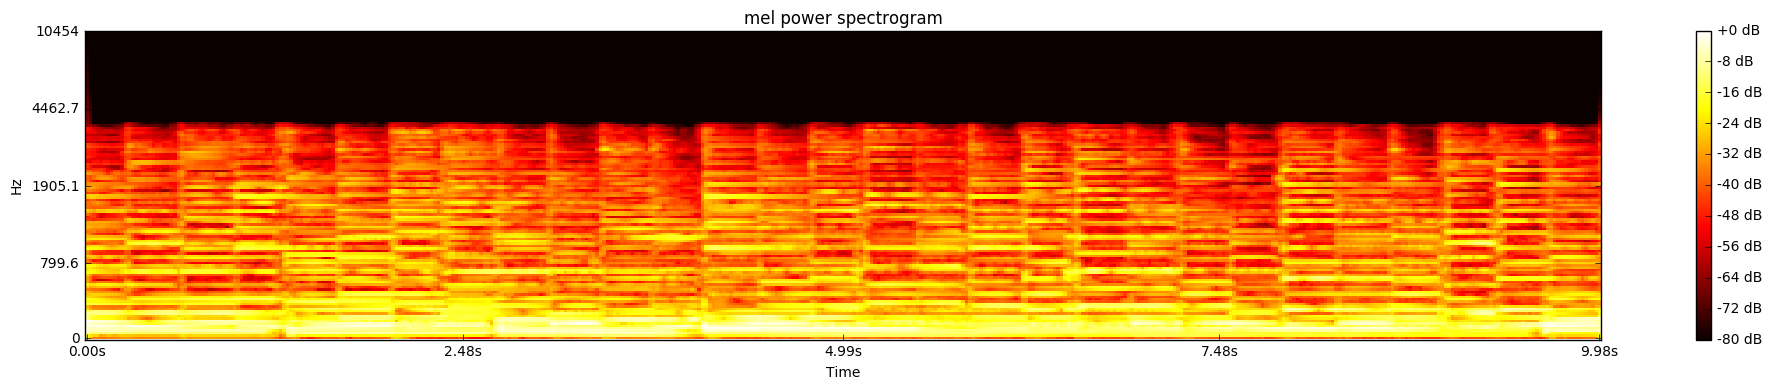

In [12]:
plt.figure(figsize=(20,4))
librosa.display.specshow(log_S, sr=sr, x_axis='time', y_axis='mel', cmap='hot')
plt.title('mel power spectrogram')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()

# Prepare the Data

В этой секции мы создадим датасет, прочитав все данные.

In [13]:
import numpy as np
X1 = np.load(os.path.join(BP, "spectrograms", "spectrograms1.pcl"))
X2 = np.load(os.path.join(BP, "spectrograms", "spectrograms2.pcl"))

In [16]:
X_1 = X1[:100]
X_2 = X2[:100]

In [ ]:
X1 = np.concatenate(X1)

Здесь вы должны получить train genres. Они идут подряд в соответствии с последовательностью треков в файлах с данными. Для содержимого первых шести файлов у вас есть жанры, а для последнего файла, вам их нужно предсказать.

In [14]:
with open(os.path.join(BP, "train_genres.txt"), "rt") as f_in:
    y = f_in.readlines()
print len(y)
y1 = y[:2000]

12000


In [15]:
num_classes = len(set(y1))

In [20]:
len(set(y))

67

In [21]:
len(set(y1))

56

# Nearest Neighbors genre classification

Let's try to solve similarity task by the nearest neighbour approach.

<img src="./img/nn.png" width="300">

Перемешаем датасет - используйте `np.random.permutation` и индексацию `a[np.random.permutation]`.

In [16]:
y1 = np.array(y1)

In [17]:
perm = np.random.permutation(y1.shape[0])
y1 = y1[perm]
X1 = X1[perm]
#Xreshape = X.reshape(X.shape[0], X.shape[1], X.shape[2])

Разобьем датасет на трейн и валидацию 80/20%.

In [19]:
Xreshape.shape

(2000, 128, 431)

In [20]:
Xreshape = X1.reshape(X1.shape[0], X1.shape[1], X1.shape[2])
X_train, X_valid = Xreshape[:1500], Xreshape[500:]
y_train, y_valid = y[:1500], y[500:]

Попробуем поклассифицировать жанры методом ближайших соседей.

In [21]:
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier()
clf = clf.fit(X_train, y_train)
y_val_pred = clf.predict(X_valid.reshape((X_valid.shape[0], -1)))

print accuracy_score(y_valid, y_val_pred)

ValueError: Found array with dim 3. Estimator expected <= 2.

# Fully-Connected Neural Nets

Использовать нейросети - это хорошая идея, давайте начнем с полносвязных сетей.

In [ ]:
import theano
import lasagne
import theano.tensor as T

from utils import train_net

Перемешаем и разобьем датасет.

In [ ]:
perm = np.random.permutation(len(y))
X, y = np.array(X)[perm].astype('float32'), np.array(y)[perm]
Xreshape = X.reshape(X.shape[0], 1, X.shape[1], X.shape[2])

X_train, X_valid = Xreshape[:10000], Xreshape[10000:]
y_train, y_valid = y[:10000], y[10000:]

In [ ]:
input_X, target_y = T.tensor4("X", dtype='float32'), T.vector("y", dtype='int32')
nn = lasagne.layers.InputLayer(shape=(None, 1, X.shape[1], X.shape[2]), input_var=input_X) 

nn = ????
#
# Используйте 2-3 больших полносвязных слоя, обучилась ли сеть? если нет то почему?
#

y_predicted = lasagne.layers.get_output(nn)
all_weights = lasagne.layers.get_all_params(nn)

loss = lasagne.objectives.categorical_crossentropy(y_predicted, target_y).mean()
accuracy = lasagne.objectives.categorical_accuracy(y_predicted, target_y).mean()
updates_sgd = ???? ваш любимый оптимизатор

In [ ]:
train_fun = theano.function([input_X, target_y], [loss, accuracy], allow_input_downcast=True, updates=updates_sgd)
test_fun  = theano.function([input_X, target_y], [loss, accuracy], allow_input_downcast=True)

In [ ]:
%time conv_nn = train_net(nn, train_fun, test_fun, X_train, y_train, X_valid, y_valid, num_epochs=10, batch_size=50)

# Convolution Neural Nets

Да, вероятно, полносвязные сети не зажгли и kNN не обогнали. Давайте попробуем сверточные, хороший вариант делать одномерные свертки (сразу по всем частотам). Хотя двумерные тоже могут работать. 

Архитектуру можно подсмотреть [тут](http://benanne.github.io/2014/08/05/spotify-cnns.html).

In [ ]:
import theano
import lasagne
import theano.tensor as T

from utils import train_net

In [ ]:
perm = np.random.permutation(len(y))
X, y = np.array(X)[perm].astype('float32'), np.array(y)[perm]
Xreshape = X.reshape(X.shape[0], X.shape[1], X.shape[2])

X_train, X_valid = Xreshape[:10000], Xreshape[10000:]
y_train, y_valid = y[:10000], y[10000:]

In [ ]:
input_X, target_y = T.tensor3("X", dtype='float64'), T.vector("y", dtype='int32')
nn = lasagne.layers.InputLayer(shape=(None, X.shape[1], X.shape[2]), input_var=input_X) 

nn = ??? Сделайте свою сеть, используя: Conv1DLayer + MaxPool1DLayer + DenseLayer

nn = lasagne.layers.DenseLayer(nn, num_classes, nonlinearity=lasagne.nonlinearities.softmax)

In [ ]:
y_predicted = lasagne.layers.get_output(nn)
all_weights = lasagne.layers.get_all_params(nn)

loss = lasagne.objectives.categorical_crossentropy(y_predicted, target_y).mean()
accuracy = lasagne.objectives.categorical_accuracy(y_predicted, target_y).mean()
updates_sgd = lasagne.updates.adam(loss, all_weights)

In [ ]:
train_fun = theano.function([input_X, target_y], [loss, accuracy], allow_input_downcast=True, updates=updates_sgd)
test_fun  = theano.function([input_X, target_y], [loss, accuracy], allow_input_downcast=True)

In [ ]:
Подумайте, какой размер батча нужен и сколько эпох вы можете себе позволить подождать
%time conv_nn = train_net(nn, train_fun, test_fun, X_train, y_train, X_valid, y_valid, num_epochs=???, batch_size=??)

Валидационная точность должна быть около 0.6 или лучше. 

Давайте нарисуем каждый второй фильтр - можете ли вы проинтерпретировать эти фильтры?

In [ ]:
plt.figure(figsize=(5, 5), dpi=500)
W = lasagne.layers.get_all_params(nn)[0].get_value()
W[::2, :, :] = 0.2
W = np.hstack(W)
pylab.imshow(W, cmap='hot', interpolation="nearest")
pylab.axis('off')
pylab.show()

# Maps of tracks by SVD and tSNE

Хорошая идея посмотреть, как полученое представление отображается с сохранением относительных расстояний на плоскость. Используйте tSNE или PCA.

Help: https://lts2.epfl.ch/blog/perekres/category/visualizing-hidden-structures-in-datasets-using-deep-learning/

In [ ]:
from sklearn.manifold import TSNE

In [ ]:
represent = lasagne.layers.get_output(nn.input_layer)
represent_fun = theano.function([input_X], [represent], allow_input_downcast=True)

In [ ]:
f = lambda x: np.array(represent_fun([x])[0])
track_vectors = map(f, X_train) + map(f, X_valid)
track_vectors = np.concatenate(track_vectors, axis=0)

track_labels = np.array(list(y_train) + list(y_valid))

получите 2d вектора

In [ ]:
X_tsne = ????

нарисуйте получившиеся точки

In [ ]:
plt.figure(figsize=(10,10), dpi=500)
colors = cm.hot(np.linspace(0, 1, len(id2gener)))

for idx, gener in id2gener.items():
    idx_ = np.where(track_labels == idx)
    pylab.scatter(????, ????, c=colors[idx], cmap=cm.hot, label=gener,s=50)

pylab.legend(loc=0, ncol=5)